# 0. Preview


 In this noteebok everything **(except pram_grid and used model)** ident with `poly_ridge.ipynb`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model    import ElasticNet

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer

In [2]:
df = pd.read_csv('../data/csv/main_data.csv')
df = df.drop_duplicates(subset=['date'], keep='first')
df = df.reset_index(drop=True)

df=df[df['date']>='2024-01-01']

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

In [3]:
df.head(10)

,date,close,volume,rsi,MACD_Cross_Power_Normalized,hash-rate,active-count,total_fee,transfer_count,zew_mood_index,zew_state,active-count_smoothed,gesi_value,MACD,Signal_Line
0,2024-01-01,44167.330214,1.842698e+10,58.51,-0.004428,5.325974e+20,835094,219.894817,5.298955e+05,23.0,1.0,835863.785714,0.01,599.951375,795.509092
1,2024-01-02,44957.970054,3.933527e+10,64.03,-0.001348,5.282397e+20,881105,142.498779,8.482888e+05,23.0,1.0,839572.714286,0.01,719.758949,780.359063
2,2024-01-03,42848.175641,4.634232e+10,45.95,-0.002674,4.825081e+20,960560,146.252758,8.582424e+05,23.0,1.0,851744.428571,0.01,637.120211,751.711293
3,2024-01-04,44179.921701,3.044809e+10,51.22,-0.001455,5.691366e+20,1025260,127.603694,1.053271e+06,23.0,1.0,866690.571429,0.01,671.350286,735.639091
4,2024-01-05,44162.691630,3.233603e+10,50.50,-0.000842,6.085781e+20,908052,116.881882,7.851296e+05,23.0,1.0,859022.142857,0.01,689.143526,726.339978
5,2024-01-06,43989.194093,1.609250e+10,50.98,-0.000817,5.010736e+20,821476,87.293147,5.619952e+05,23.0,1.0,852866.142857,0.01,681.390352,717.350053
6,2024-01-07,43943.097229,1.933057e+10,54.13,-0.000974,5.176165e+20,728196,76.293109,5.733454e+05,23.0,1.0,838324.785714,0.01,663.873553,706.654753
7,2024-01-08,46970.502314,4.274619e+10,62.69,0.003022,4.077691e+20,782552,124.929503,8.468302e+05,23.0,1.0,843738.928571,0.01,884.086455,742.141093
8,2024-01-09,46139.730375,3.982129e+10,63.90,0.004129,4.974005e+20,938139,112.113247,1.140367e+06,23.0,1.0,857584.214286,0.01,980.270465,789.766968
9,2024-01-10,46627.779112,5.011461e+10,62.55,0.005038,5.095785e+20,857481,84.057623,1.313567e+06,23.0,1.0,863405.285714,0.01,1083.389798,848.491534


In [4]:
df.columns

Index(['date', 'close', 'volume', 'rsi', 'MACD_Cross_Power_Normalized',
       'hash-rate', 'active-count', 'total_fee', 'transfer_count',
       'zew_mood_index', 'zew_state', 'active-count_smoothed', 'gesi_value',
       'MACD', 'Signal_Line'],
      dtype='object')

# 1. Feature Engineering

## 1.1 Statistical values

In [5]:
df['close_change'] = df['close'].pct_change(3)  # ПРОЦЕНТНОЕ Изменение за 3 дня

# Создание новых признаков
df['hash_rate_ma_7'] = df['hash-rate'].rolling(7).mean()
df['close_ma_7'] = df['close'].shift(1).rolling(7, min_periods=1).mean() #с какой целью здесь shift(1) - чтобы модель не подглядывала
df['volume_ma_7'] = df['volume'].rolling(window=7).mean() #скользящее среднее по объему

df['price_momentum_7d'] = df['close'].pct_change(periods=7) #процентное изменение за 7 дней
df['volume_ratio_7d'] = df['volume'] / df['volume_ma_7'] #по приколу ввели

df['active_count_ma_7'] = df['active-count'].rolling(window=7).mean() #то же самое скользящее среднее

df['hash_active_count_7dirived'] = df['hash-rate']/df['active_count_ma_7'] #как же чувствуем - признк пальцем в небо (почти)

df['returns'] = df['close'].pct_change() # ---||---
df['volatility_14d'] = df['returns'].rolling(window=14).std() #скользящее стандартное отклонения

df['rsi_divergence'] = df['rsi'] - df['close'] #добавил
#не просто разность, а процентное изменение

df['fee_to_volume_ratio'] = df['total_fee'] / df['volume'] #все понято

df['macd_signal_diff'] = df['MACD'] - df['Signal_Line'] #когда MACD пересекает сигнал - это мощный намек

df['zew_mood_ma_3'] = df['zew_mood_index'].shift(1).rolling(3).mean() #по сути это тоже лаги, но со скользищим средним
df['zew_mood_ma_7'] = df['zew_mood_index'].shift(1).rolling(7).mean() # ---||---

df['total_fee_ma_3'] = df['total_fee'].shift(1).rolling(3).mean() #и снова тут лаги со скользящими средними
df['total_fee_ma_7'] = df['total_fee'].shift(1).rolling(7).mean() #---||---
df['total_fee_ma_14'] = df['total_fee'].shift(1).rolling(14).mean() #---||---


## 1.1(*) Honarible Mention

In [6]:
df['hash_active_count_7dirived'] = df['hash_rate_ma_7']/(df['active_count_ma_7'] *df['volume'])
df['hash_active_count_dirived14'] = df['hash_active_count_7dirived'].rolling(window=14).mean()

## 1.2 Lag features

In [7]:
def create_lag_features(df, columns, n_lags=4):
    df = df.copy()
    for col in columns:
        for lag in range(1, n_lags+1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)  # shift(lag) - ПРОШЛЫЕ данные
    return df

In [8]:
df[['date', 'close']]

,date,close
0,2024-01-01,44167.330214
1,2024-01-02,44957.970054
2,2024-01-03,42848.175641
3,2024-01-04,44179.921701
4,2024-01-05,44162.691630
...,...,...
528,2025-07-04,108034.339050
529,2025-07-05,108231.181990
530,2025-07-06,109232.069735
531,2025-07-07,108299.851088


In [9]:
df['price_change'] = (df['close'] > df['close'].shift(1))

features_to_lag = ['close', 'close_change', 'volume','rsi', 'MACD_Cross_Power_Normalized', 'hash-rate',
                   'active-count', 'total_fee', 'transfer_count', 'zew_state', 'zew_mood_index', 'gesi_value'
                   ]
features_to_lag

['close',
 'close_change',
 'volume',
 'rsi',
 'MACD_Cross_Power_Normalized',
 'hash-rate',
 'active-count',
 'total_fee',
 'transfer_count',
 'zew_state',
 'zew_mood_index',
 'gesi_value']

In [10]:
df = create_lag_features(df, features_to_lag)
df.columns

Index(['date', 'close', 'volume', 'rsi', 'MACD_Cross_Power_Normalized',
       'hash-rate', 'active-count', 'total_fee', 'transfer_count',
       'zew_mood_index', 'zew_state', 'active-count_smoothed', 'gesi_value',
       'MACD', 'Signal_Line', 'close_change', 'hash_rate_ma_7', 'close_ma_7',
       'volume_ma_7', 'price_momentum_7d', 'volume_ratio_7d',
       'active_count_ma_7', 'hash_active_count_7dirived', 'returns',
       'volatility_14d', 'rsi_divergence', 'fee_to_volume_ratio',
       'macd_signal_diff', 'zew_mood_ma_3', 'zew_mood_ma_7', 'total_fee_ma_3',
       'total_fee_ma_7', 'total_fee_ma_14', 'hash_active_count_dirived14',
       'price_change', 'close_lag_1', 'close_lag_2', 'close_lag_3',
       'close_lag_4', 'close_change_lag_1', 'close_change_lag_2',
       'close_change_lag_3', 'close_change_lag_4', 'volume_lag_1',
       'volume_lag_2', 'volume_lag_3', 'volume_lag_4', 'rsi_lag_1',
       'rsi_lag_2', 'rsi_lag_3', 'rsi_lag_4',
       'MACD_Cross_Power_Normalized_lag_

In [11]:
df['target_close'] = df['close'].shift(-1)

In [12]:
df[['date', 'close', 'target_close']]

,date,close,target_close
0,2024-01-01,44167.330214,44957.970054
1,2024-01-02,44957.970054,42848.175641
2,2024-01-03,42848.175641,44179.921701
3,2024-01-04,44179.921701,44162.691630
4,2024-01-05,44162.691630,43989.194093
...,...,...,...
528,2025-07-04,108034.339050,108231.181990
529,2025-07-05,108231.181990,109232.069735
530,2025-07-06,109232.069735,108299.851088
531,2025-07-07,108299.851088,108950.275543


In [13]:
df = df.dropna()


In [14]:
selected_features = [
    #'close_lag_4',
    #'zew_mood_index_lag_1', 'zew_mood_index_lag_2', 'zew_mood_index_lag_3',
    #'active-count_lag_1', 'active-count_lag_2',
    #'active-count_lag_3', 'active-count_lag_4', 'active-count_lag_5',
    'hash_active_count_dirived14',
    #'total_fee_lag_1', 'total_fee_lag_2', 'total_fee_lag_3',
    #'transfer_count_lag_1', 'transfer_count_lag_3',
    #'close_change_lag_2', 'close_change_lag_3',
    #'volume_lag_1', 'volume_lag_2', 'volume_lag_3',
    #'hash-rate_lag_1', 'hash-rate_lag_2', 'hash-rate_lag_3',
    'rsi',
    #'MACD',
    'MACD_Cross_Power_Normalized',
    #'rsi_lag_1', 'rsi_lag_2',
    #'MACD_Cross_Power_Normalized_lag_1', 'MACD_Cross_Power_Normalized_lag_2',
    #'rub_usd_lag_1', 'rub_usd_lag_2' , 'rub_usd_lag_3',
    #'gesi_value_lag_1', 'gesi_value_lag_2', 'gesi_value_lag_3',
    'close_ma_7',
    'volume_ma_7',
    #'yuan_lag_1', 'yuan_lag_2', 'yuan_lag_3',
    #'zew_state_lag_1',
    #'zew_mood_ma_3',
    #'zew_mood_ma_7',
    'total_fee_ma_3', #'total_fee_ma_7', 'total_fee_ma_14',
    'hash_active_count_7dirived',
    'price_momentum_7d',
    'volume_ratio_7d',
    #'volatility_14d',
    #'rsi_divergence',
    'fee_to_volume_ratio',
    'macd_signal_diff'
]

## 1.3 Polynomial Features

In [15]:
from sklearn.preprocessing import PolynomialFeatures

In [16]:
PolyTransformer = PolynomialFeatures(degree=3)

In [17]:
X = PolyTransformer.fit_transform(df[selected_features])
y = df['target_close']

In [18]:
df[selected_features].shape

(513, 11)

In [19]:
X.shape

(513, 364)

# 2. Learning

## 2.1 Train Test Split via `TimeSeriesSplit`

In [20]:
train_size = int(len(df) * 0.8)

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

In [21]:
X_train.shape, y_train.shape

((410, 364), (410,))

In [22]:
X_test.shape, y_test.shape

((103, 364), (103,))

In [23]:
test_dates = df.iloc[train_size:]['date']

In [24]:

tscv = TimeSeriesSplit(
    n_splits=5,          
    test_size=30,        
    gap=7,               
)

## 2.2 Custom metrics and Scoring

In [25]:
def NMAPE(y_true, y_pred):
    return 1 - np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def directional_accuracy(y_true, y_pred):
    """Точность предсказания направления изменения"""
    true_direction = np.sign(np.diff(y_true))
    pred_direction = np.sign(np.diff(y_pred))
    return np.mean(true_direction == pred_direction)


def symmetric_mape(y_true, y_pred):
    """SMAPE метрика (более сбалансированная)"""
    return np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

In [26]:
refit = 'r2'
scoring = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'mape': make_scorer(NMAPE),
    # 'mse': 'neg_mean_squared_error',                           # adjust to emissions 
    'directional_accuracy': make_scorer(directional_accuracy),
    'symmetric_mape': make_scorer(symmetric_mape),
}

# May be too much

## 2.3 Grid Search for L2

In [27]:
ElasticNet().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [28]:
e_net_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model',  ElasticNet(random_state=42))
])

In [29]:
e_net_param_grid = {
    'model__alpha':        [0.001, 0.01, 0.1, 1, 10, 100],
    'model__l1_ratio':     [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
    'model__random_state': [42],
    'model__max_iter' :    [int(1e6)]
}

In [30]:

e_net_grid_search = GridSearchCV(
    estimator=e_net_pipeline,
    param_grid=e_net_param_grid,
    cv=tscv,
    scoring=scoring,
    n_jobs=7,
    # verbose=3,
    refit=refit
)

In [31]:
e_net_grid_search.fit(X_train, y_train)


/home/makra/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.082e+08, tolerance: 1.358e+06
  model = cd_fast.enet_coordinate_descent(
/home/makra/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.761e+08, tolerance: 1.358e+06
  model = cd_fast.enet_coordinate_descent(
/home/makra/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.48

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__alpha': [0.001, 0.01, ...], 'model__l1_ratio': [0.01, 0.1, ...], 'model__max_iter': [1000000], 'model__random_state': [42]}"
,scoring,"{'directional_accuracy': make_scorer(d...hod='predict'), 'mae': 'neg_mean_absolute_error', 'mape': make_scorer(N...hod='predict'), 'r2': 'r2', ...}"
,n_jobs,7
,refit,'r2'
,cv,TimeSeriesSpl... test_size=30)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [32]:
best_e_net = e_net_grid_search.best_estimator_

In [33]:
best_e_net.steps[1][1].get_params()

{'alpha': 100,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 1,
 'max_iter': 1000000,
 'positive': False,
 'precompute': False,
 'random_state': 42,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [34]:
from joblib import dump

In [35]:
dump(best_e_net, 'model__ElasticNet_poly.joblib')

['model__ElasticNet_poly.joblib']

# 3 Evaluating model

## 3.1 Metrics 

In [36]:
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mape = NMAPE(y_test, predictions)
    Symmetric_mape = symmetric_mape(y_test, predictions)


    print(f"{model_name}:")
    print(f"symmetric_mape: {Symmetric_mape:.4f}")
    print(f"mape: {mape:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    print("-" * 30)

    return predictions

In [38]:
e_net_pred = evaluate_model(best_e_net, X_test, y_test, "Ridge")

Ridge:
symmetric_mape: 2.0028
mape: -0.9934
MSE: 5648307.6294
R²: 0.9450
------------------------------


## 3.1 Features importance

In [39]:
def get_importance(model, features):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0])
    else:
        raise ValueError("Model does not have feature importances.")

    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': importance
    }).sort_values(by='importance', ascending=False)

    return feature_importance


# feature_importanceRidge = pd.DataFrame({
#     'feature': selected_features,
#     'importance': best_ridge.named_steps['model'].coef_ #best_ridge.named_steps['model'].feature_importances_
# }).sort_values('importance', ascending=False)

# print(feature_importanceRidge.head(5))

In [40]:
importance_dict = {best_e_net.steps[1][1].coef_[i] : PolyTransformer.get_feature_names_out()[i] for i in range(len(best_e_net.steps[1][1].coef_))}
importance_dict

{np.float64(0.0): 'macd_signal_diff^3',
 np.float64(14969.1840106823): 'close_ma_7',
 np.float64(167.54600608962932): 'price_momentum_7d',
 np.float64(801.7514708600099): 'close_ma_7 price_momentum_7d',
 np.float64(-11.555039790281935): 'hash_active_count_dirived14^3',
 np.float64(-39.6808897525275): 'hash_active_count_dirived14^2 total_fee_ma_3',
 np.float64(-53.12606808586512): 'hash_active_count_dirived14^2 volume_ratio_7d',
 np.float64(470.36107141132436): 'hash_active_count_dirived14 volume_ma_7^2',
 np.float64(1030.8387116097424): 'rsi close_ma_7^2',
 np.float64(-69.07516744129416): 'rsi hash_active_count_7dirived macd_signal_diff',
 np.float64(-4.687843973078409): 'MACD_Cross_Power_Normalized^3',
 np.float64(1130.724867474709): 'close_ma_7 price_momentum_7d volume_ratio_7d',
 np.float64(375.3646526739745): 'volume_ma_7 hash_active_count_7dirived volume_ratio_7d',
 np.float64(-188.57393524382127): 'volume_ma_7 hash_active_count_7dirived macd_signal_diff',
 np.float64(-70.33875385

In [41]:
coefs = list(importance_dict.keys())
coefs.sort(key=lambda x: abs(x))

most_important = coefs[-30:]
most_important = most_important[::-1]
most_important

[np.float64(14969.1840106823),
 np.float64(1130.724867474709),
 np.float64(1030.8387116097424),
 np.float64(801.7514708600099),
 np.float64(470.36107141132436),
 np.float64(390.8146652669986),
 np.float64(375.3646526739745),
 np.float64(-188.57393524382127),
 np.float64(167.54600608962932),
 np.float64(-70.33875385008449),
 np.float64(-69.07516744129416),
 np.float64(-65.06966024122964),
 np.float64(-53.12606808586512),
 np.float64(-39.6808897525275),
 np.float64(38.17890523907594),
 np.float64(-11.555039790281935),
 np.float64(-4.687843973078409),
 np.float64(0.0)]

In [42]:
i = 0
for coef in most_important:
    i += 1
    print(f'Feature {i}: Value : {coef.round(2)} ||  Label: {importance_dict[coef]} ')

Feature 1: Value : 14969.18 ||  Label: close_ma_7 
Feature 2: Value : 1130.72 ||  Label: close_ma_7 price_momentum_7d volume_ratio_7d 
Feature 3: Value : 1030.84 ||  Label: rsi close_ma_7^2 
Feature 4: Value : 801.75 ||  Label: close_ma_7 price_momentum_7d 
Feature 5: Value : 470.36 ||  Label: hash_active_count_dirived14 volume_ma_7^2 
Feature 6: Value : 390.81 ||  Label: hash_active_count_7dirived price_momentum_7d volume_ratio_7d 
Feature 7: Value : 375.36 ||  Label: volume_ma_7 hash_active_count_7dirived volume_ratio_7d 
Feature 8: Value : -188.57 ||  Label: volume_ma_7 hash_active_count_7dirived macd_signal_diff 
Feature 9: Value : 167.55 ||  Label: price_momentum_7d 
Feature 10: Value : -70.34 ||  Label: total_fee_ma_3^2 macd_signal_diff 
Feature 11: Value : -69.08 ||  Label: rsi hash_active_count_7dirived macd_signal_diff 
Feature 12: Value : -65.07 ||  Label: total_fee_ma_3 volume_ratio_7d^2 
Feature 13: Value : -53.13 ||  Label: hash_active_count_dirived14^2 volume_ratio_7d 
Fe

## 3.2 Visualization

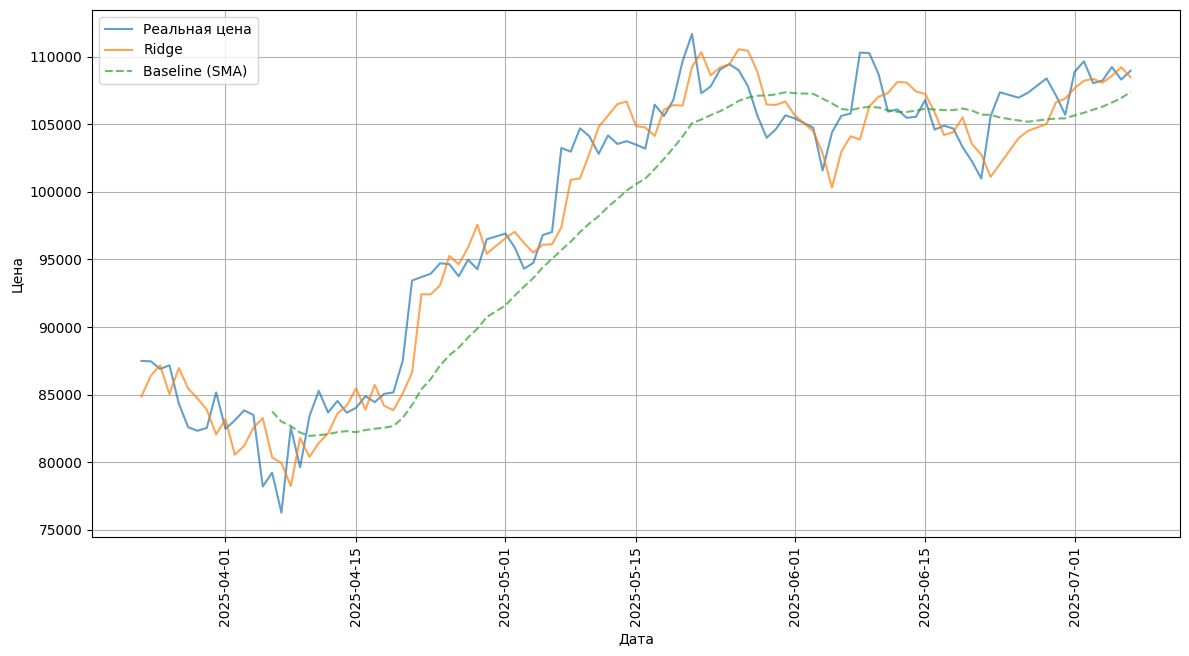

Founded Hyperparams for Elastic Net: {'memory': None, 'steps': [('scaler', StandardScaler()), ('model', ElasticNet(alpha=100, l1_ratio=1, max_iter=1000000, random_state=42))], 'transform_input': None, 'verbose': False, 'scaler': StandardScaler(), 'model': ElasticNet(alpha=100, l1_ratio=1, max_iter=1000000, random_state=42), 'scaler__copy': True, 'scaler__with_mean': True, 'scaler__with_std': True, 'model__alpha': 100, 'model__copy_X': True, 'model__fit_intercept': True, 'model__l1_ratio': 1, 'model__max_iter': 1000000, 'model__positive': False, 'model__precompute': False, 'model__random_state': 42, 'model__selection': 'cyclic', 'model__tol': 0.0001, 'model__warm_start': False}


In [45]:
plt.figure(figsize=(12, 6))
window_size = 15
sma_baseline = y_test.rolling(window=window_size).mean()
aligned_test_dates = test_dates[:len(sma_baseline)]

# Проверяем, чтобы не было NaN
sma_values = sma_baseline.dropna()
aligned_test_dates = aligned_test_dates[len(sma_baseline) - len(sma_values):]

plt.plot(test_dates,y_test.values, label='Реальная цена', alpha=0.7)
# plt.plot(rf_pred, label='Random Forest', alpha=0.7)
#plt.plot(test_dates,gb_pred, label='Gradient Boosting', alpha=0.7)
plt.plot(test_dates,e_net_pred, label='Ridge', alpha=0.7)
#plt.plot(test_dates[:len(sma_baseline)],sma_baseline.values, label='Baseline', alpha=0.7)
plt.plot(aligned_test_dates, sma_values.values, label='Baseline (SMA)', alpha=0.7, linestyle='--')

plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid()
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

print("Founded Hyperparams for Elastic Net:", best_e_net.get_params())